# Stock Data Collection and Basic Cleaning
This notebook fetches historical stock data for 20 selected companies and performs basic cleaning operations. The cleaned datasets will be saved to `data/general_cleaned/` for further processing by model-specific preparation notebooks.

## Steps:
1. Import necessary libraries
2. Define companies list
3. Fetch historical data using yfinance
4. Perform basic cleaning
5. Visualize the data
6. Save cleaned datasets


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


## 1. Define Stock List

Using the 20 companies specified for this project.


In [12]:
# Define list of companies with symbols
stocks = [
    "AAPL", "MSFT", "GOOG", "AMZN", "TSLA", 
    "FB", "NVDA", "SPY", "V", "DIS", 
    "NFLX", "PYPL", "BABA", "IBM", "AMD", 
    "BA", "INTC", "T", "GS", "NKE"
]

# Note: FB is now META, but we'll try both to ensure we get data
if "FB" in stocks:
    stocks.append("META")
    
print(f"Total stocks to analyze: {len(stocks)}")


Total stocks to analyze: 21


## 2. Create Output Directory


In [13]:
# Create output directory if it doesn't exist
output_dir = '../data/general_cleaned/'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {os.path.abspath(output_dir)}")


Output directory: /home/abderrahmane/Stock-Market-Predictor/data/general_cleaned


## 3. Define Data Fetching Function

We'll fetch 10 years of historical data for each stock to have sufficient data for training.


In [14]:
"""
    Fetch historical stock data for a given ticker symbol.
    
    Parameters:
    - ticker: Stock symbol
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame with historical stock data
    """
def fetch_stock_data(ticker, start_date, end_date):
    
    try:
        # Fetch data using yfinance
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        
        # Check if we got any data
        if df.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Add ticker column
        df['Symbol'] = ticker
        
        # Get company info for additional metadata
        try:
            info = stock.info
            df['Sector'] = info.get('sector', 'Unknown')
            df['Industry'] = info.get('industry', 'Unknown')
        except:
            print(f"Could not retrieve company info for {ticker}")
            df['Sector'] = 'Unknown'
            df['Industry'] = 'Unknown'
        
        print(f"Successfully fetched data for {ticker}: {len(df)} rows")
        return df
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None


## 4. Define Data Cleaning Function


In [15]:
def clean_stock_data(df):
    """
    Perform basic cleaning operations on stock data.
    
    Parameters:
    - df: DataFrame with stock data
    
    Returns:
    - Cleaned DataFrame
    """
    if df is None or df.empty:
        return None
    
    # Make a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Reset index to make Date a column
    df_clean = df_clean.reset_index()
    
    # Ensure Date column is datetime
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    
    # Rename columns to standard format
    df_clean = df_clean.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume',
        'Dividends': 'dividends',
        'Stock Splits': 'splits',
        'Symbol': 'symbol',
        'Date': 'date'
    })
    
    # Handle missing values
    df_clean[['open', 'high', 'low', 'close']] = df_clean[['open', 'high', 'low', 'close']].fillna(method='ffill')
    df_clean['volume'] = df_clean['volume'].fillna(0)
    df_clean['dividends'] = df_clean['dividends'].fillna(0)
    df_clean['splits'] = df_clean['splits'].fillna(0)
    
    # Add some derived features
    df_clean['return'] = df_clean['close'].pct_change()
    df_clean['ma5'] = df_clean['close'].rolling(window=5).mean()
    df_clean['ma20'] = df_clean['close'].rolling(window=20).mean()
    df_clean['ma50'] = df_clean['close'].rolling(window=50).mean()
    df_clean['volatility'] = df_clean['return'].rolling(window=20).std()
    df_clean['volume_ma20'] = df_clean['volume'].rolling(window=20).mean()
    
    df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['year'] = df_clean['date'].dt.year
    
    # Handle NaN values created by rolling calculations
    df_clean = df_clean.fillna(method='bfill')
    df_clean = df_clean.dropna()
    
    # Drop rows with extreme values (potential data errors)
    df_clean = df_clean[(df_clean['return'] > -0.5) & (df_clean['return'] < 0.5)]
    
    # Add target variable for next day's closing price
    df_clean['next_day_close'] = df_clean['close'].shift(-1)
    
    # Add target variable for price movement direction
    df_clean['price_up'] = (df_clean['next_day_close'] > df_clean['close']).astype(int)
    
    # Drop the last row since we don't have next_day_close for it
    df_clean = df_clean[:-1]
    
    return df_clean


## 5. Define Visualization Function


In [16]:
def visualize_stock_data(df, ticker):
    """
    Create visualizations for the stock data.
    
    Parameters:
    - df: DataFrame with stock data
    - ticker: Stock symbol
    """
    if df is None or df.empty:
        print(f"No data to visualize for {ticker}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 16))
    
    # Plot 1: Price history with moving averages
    axes[0].plot(df['date'], df['close'], label='Close Price')
    axes[0].plot(df['date'], df['ma20'], label='20-day MA', alpha=0.7)
    axes[0].plot(df['date'], df['ma50'], label='50-day MA', alpha=0.7)
    axes[0].set_title(f'{ticker} - Price History')
    axes[0].set_ylabel('Price ($)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Volume
    axes[1].bar(df['date'], df['volume'], alpha=0.7, color='blue')
    axes[1].plot(df['date'], df['volume_ma20'], color='red', alpha=0.7, label='20-day Volume MA')
    axes[1].set_title(f'{ticker} - Trading Volume')
    axes[1].set_ylabel('Volume')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot 3: Returns and Volatility
    ax3 = axes[2]
    ax3.plot(df['date'], df['return'], label='Daily Returns', alpha=0.5, color='green')
    ax3.set_ylabel('Returns', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.set_title(f'{ticker} - Returns and Volatility')
    
    ax3b = ax3.twinx()
    ax3b.plot(df['date'], df['volatility'], label='Volatility (20-day)', color='red', alpha=0.7)
    ax3b.set_ylabel('Volatility', color='red')
    ax3b.tick_params(axis='y', labelcolor='red')
    
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3b.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Price Up Distribution
    plt.figure(figsize=(8, 6))
    price_up_counts = df['price_up'].value_counts()
    plt.pie(price_up_counts, labels=['Down', 'Up'], autopct='%1.1f%%', colors=['red', 'green'])
    plt.title(f'{ticker} - Price Direction Distribution')
    plt.show()
    
    # Monthly Returns
    monthly_returns = df.groupby('month')['return'].mean()
    plt.figure(figsize=(10, 6))
    monthly_returns.plot(kind='bar', color=['green' if x > 0 else 'red' for x in monthly_returns])
    plt.title(f'{ticker} - Average Monthly Returns')
    plt.xlabel('Month')
    plt.ylabel('Average Return')
    plt.grid(True, alpha=0.3)
    plt.show()


## 6. Fetch and Clean Data for All Stocks


In [17]:
# Define date range (10 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)  # 10 years

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Process each stock
results = {}

for ticker in stocks:
    print(f"\nProcessing {ticker}...")
    
    # Fetch data
    df = fetch_stock_data(ticker, start_date, end_date)
    
    if df is not None and not df.empty:
        # Clean data
        cleaned_df = clean_stock_data(df)
        
        if cleaned_df is not None and not cleaned_df.empty:
            results[ticker] = cleaned_df
            print(f"Cleaned data shape for {ticker}: {cleaned_df.shape}")
            
            # Save cleaned data
            output_file = os.path.join(output_dir, f"{ticker}.csv")
            cleaned_df.to_csv(output_file, index=False)
            print(f"Saved cleaned data to {output_file}")
        else:
            print(f"No clean data available for {ticker} after processing")
    else:
        print(f"Skipping {ticker} due to data fetch issues")

print(f"\nSuccessfully processed {len(results)} out of {len(stocks)} stocks")


Fetching data from 2015-05-12 to 2025-05-09

Processing AAPL...
Successfully fetched data for AAPL: 2514 rows
Cleaned data shape for AAPL: (2513, 22)
Saved cleaned data to ../data/general_cleaned/AAPL.csv

Processing MSFT...
Successfully fetched data for MSFT: 2514 rows
Cleaned data shape for MSFT: (2513, 22)
Saved cleaned data to ../data/general_cleaned/MSFT.csv

Processing GOOG...
Successfully fetched data for GOOG: 2514 rows
Cleaned data shape for GOOG: (2513, 22)
Saved cleaned data to ../data/general_cleaned/GOOG.csv

Processing AMZN...
Successfully fetched data for AMZN: 2514 rows
Cleaned data shape for AMZN: (2513, 22)
Saved cleaned data to ../data/general_cleaned/AMZN.csv

Processing TSLA...
Successfully fetched data for TSLA: 2514 rows
Cleaned data shape for TSLA: (2513, 22)
Saved cleaned data to ../data/general_cleaned/TSLA.csv

Processing FB...


$FB: possibly delisted; no timezone found


No data found for FB
Skipping FB due to data fetch issues

Processing NVDA...
Successfully fetched data for NVDA: 2514 rows
Cleaned data shape for NVDA: (2513, 22)
Saved cleaned data to ../data/general_cleaned/NVDA.csv

Processing SPY...
Successfully fetched data for SPY: 2514 rows
Cleaned data shape for SPY: (2513, 23)
Saved cleaned data to ../data/general_cleaned/SPY.csv

Processing V...
Successfully fetched data for V: 2514 rows
Cleaned data shape for V: (2513, 22)
Saved cleaned data to ../data/general_cleaned/V.csv

Processing DIS...
Successfully fetched data for DIS: 2514 rows
Cleaned data shape for DIS: (2513, 22)
Saved cleaned data to ../data/general_cleaned/DIS.csv

Processing NFLX...
Successfully fetched data for NFLX: 2514 rows
Cleaned data shape for NFLX: (2513, 22)
Saved cleaned data to ../data/general_cleaned/NFLX.csv

Processing PYPL...
Successfully fetched data for PYPL: 2478 rows
Cleaned data shape for PYPL: (2477, 22)
Saved cleaned data to ../data/general_cleaned/PYPL.

## 7. Visualize Each Stock


In [ ]:
# Visualize each stock's data
for ticker, df in results.items():
    print(f"\nVisualizing {ticker}...")
    visualize_stock_data(df, ticker)
    
    # Display some basic statistics
    print(f"\n{ticker} Statistics:")
    print(f"Data range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total trading days: {len(df)}")
    print(f"Average daily return: {df['return'].mean():.4f}")
    print(f"Standard deviation of returns: {df['return'].std():.4f}")
    print(f"Price increase frequency: {df['price_up'].mean():.4f} ({df['price_up'].sum()} out of {len(df)})")
    
    # Display correlation matrix for selected columns
    corr_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'volatility', 'ma20', 'price_up']
    corr_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"{ticker} - Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()


## 8. Summary Statistics Across All Stocks


In [18]:
# Calculate summary statistics across all stocks
summary_stats = []

for ticker, df in results.items():
    stats = {
        'Symbol': ticker,
        'Start Date': df['date'].min(),
        'End Date': df['date'].max(),
        'Trading Days': len(df),
        'Avg Daily Return': df['return'].mean(),
        'Return Std Dev': df['return'].std(),
        'Volatility (avg)': df['volatility'].mean(),
        'Price Up Ratio': df['price_up'].mean(),
        'Current Price': df.iloc[-1]['close'],
        'Price Change (%)': ((df.iloc[-1]['close'] / df.iloc[0]['close']) - 1) * 100,
        'Avg Volume': df['volume'].mean()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values('Avg Daily Return', ascending=False)

# Display summary statistics
summary_df


,Symbol,Start Date,End Date,Trading Days,Avg Daily Return,Return Std Dev,Volatility (avg),Price Up Ratio,Current Price,Price Change (%),Avg Volume
5,NVDA,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.002669,0.031525,0.028980,0.543971,117.370003,23154.748670,4.681340e+08
13,AMD,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2512,0.001959,0.035753,0.034422,0.505971,101.699997,4191.139319,5.877110e+07
4,TSLA,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.001824,0.037022,0.033898,0.516514,284.820007,1656.846837,1.133739e+08
9,NFLX,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.001427,0.027252,0.024781,0.510147,1144.430054,1280.946799,8.451515e+06
19,META,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.001119,0.024140,0.021266,0.528054,598.010010,665.971938,2.260132e+07
1,MSFT,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.001098,0.017159,0.015448,0.536013,438.170013,965.894328,2.833623e+07
3,AMZN,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.001093,0.020690,0.018859,0.534421,192.080002,799.946122,7.516809e+07
0,AAPL,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.000954,0.018477,0.016589,0.530044,197.490005,598.855351,1.113345e+08
2,GOOG,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.000881,0.018340,0.016785,0.539594,155.750000,490.943292,3.017820e+07
7,V,2015-05-13 00:00:00-04:00,2025-05-08 00:00:00-04:00,2513,0.000805,0.015538,0.013662,0.551930,351.269989,447.743252,7.981399e+06


## 9. Visualize Comparative Performance

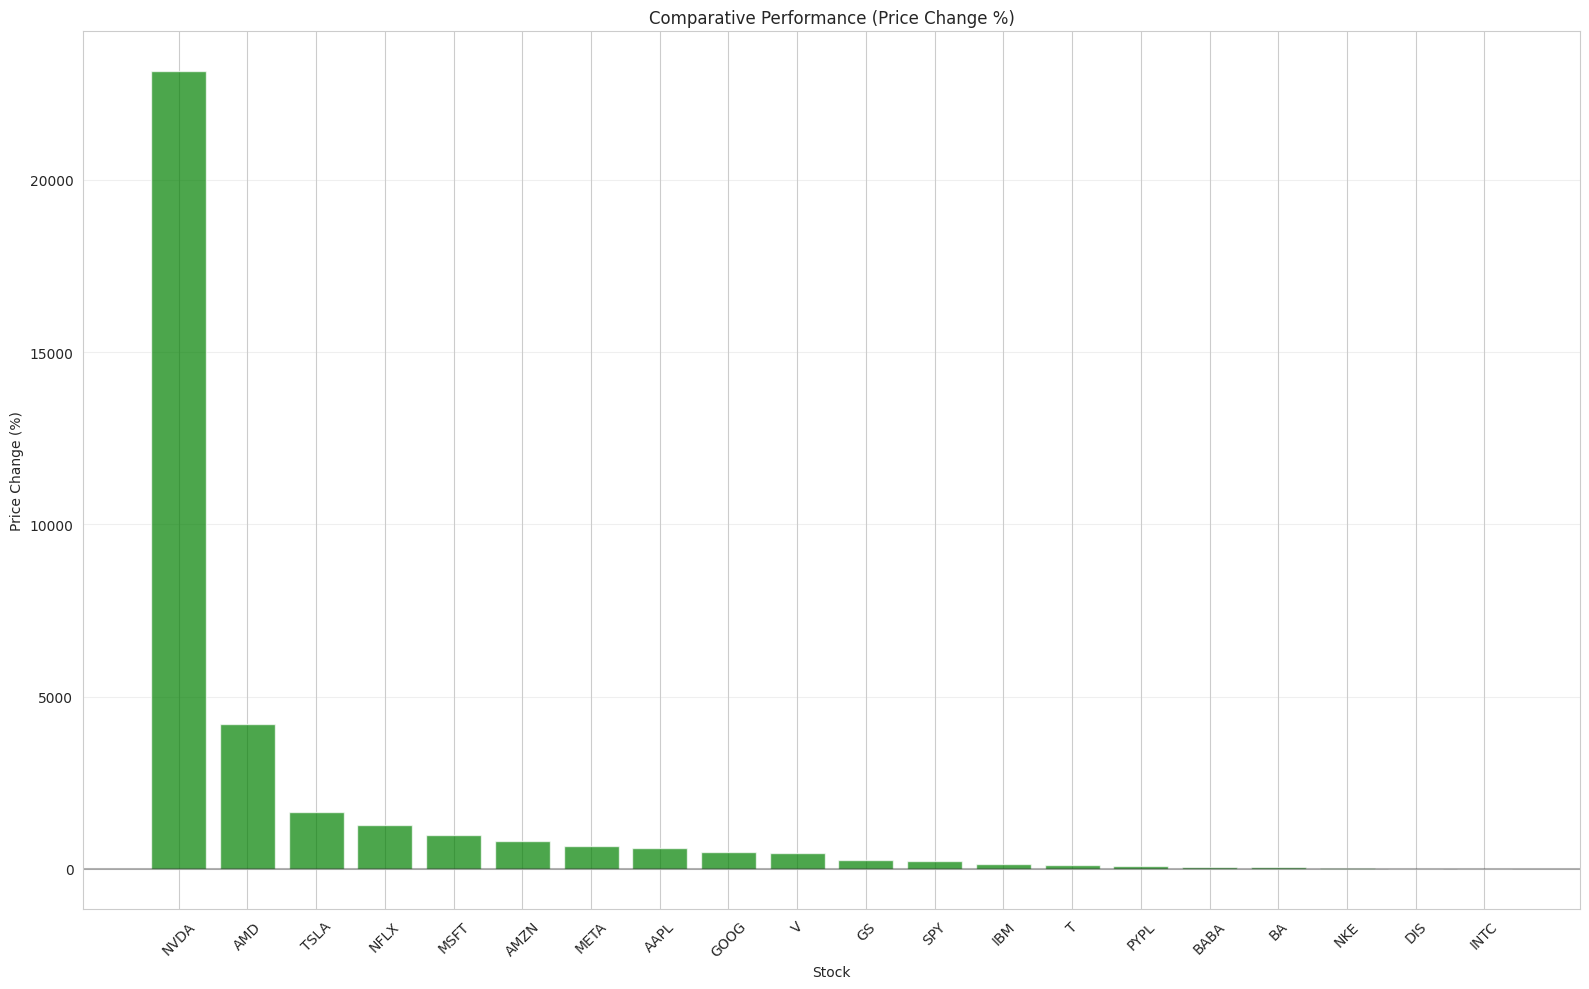

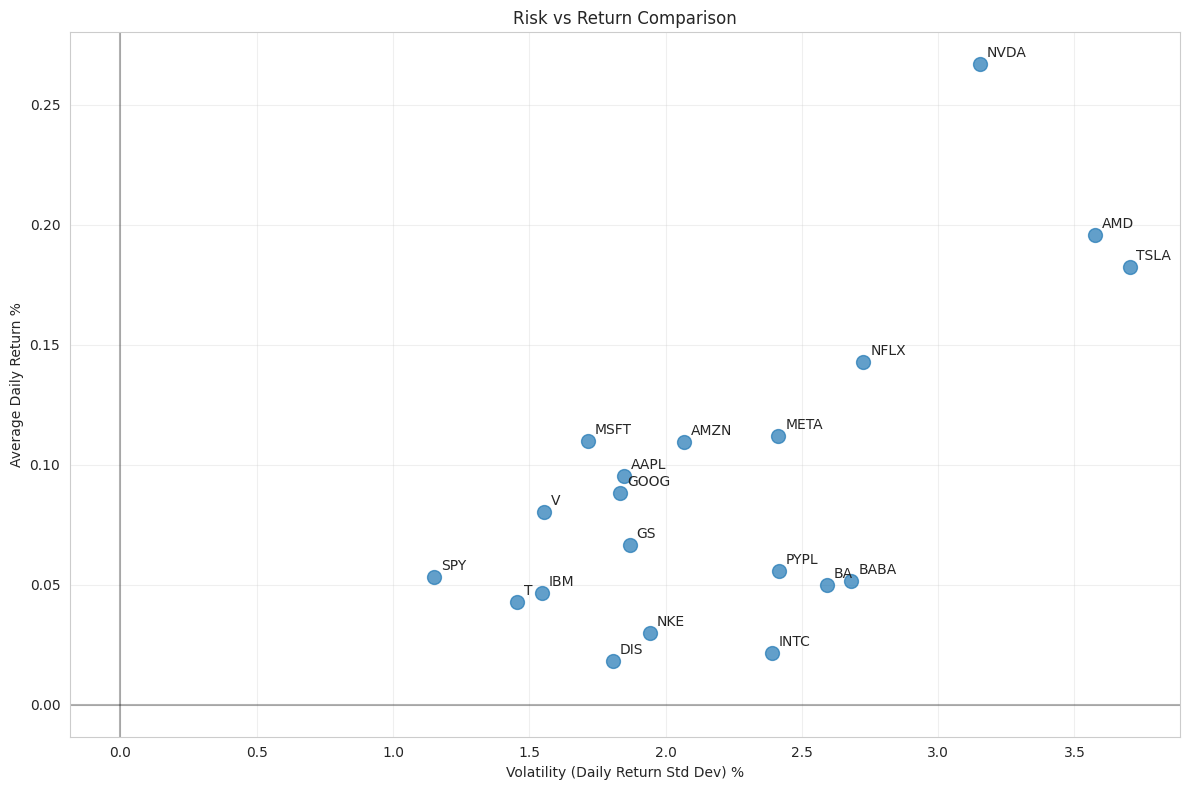

In [19]:
# Comparative Performance Plot (Price Change %)
plt.figure(figsize=(16, 10))

# Sort for better visual ordering
summary_sorted = summary_df.sort_values('Price Change (%)', ascending=False)

# Set color: green for gains, red for losses
colors = ['green' if x > 0 else 'red' for x in summary_sorted['Price Change (%)']]

# Bar plot
plt.bar(summary_sorted['Symbol'], summary_sorted['Price Change (%)'], color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Labels & layout
plt.title('Comparative Performance (Price Change %)')
plt.xlabel('Stock')
plt.ylabel('Price Change (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Risk vs Return Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(summary_df['Return Std Dev'] * 100,
            summary_df['Avg Daily Return'] * 100,
            s=100, alpha=0.7)

# Add symbol labels to each point
for i, row in summary_df.iterrows():
    plt.annotate(row['Symbol'],
                 (row['Return Std Dev'] * 100, row['Avg Daily Return'] * 100),
                 xytext=(5, 5), textcoords='offset points')

# Reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Labels & layout
plt.title('Risk vs Return Comparison')
plt.xlabel('Volatility (Daily Return Std Dev) %')
plt.ylabel('Average Daily Return %')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


10. Data Quality Check

In [20]:
# Data Quality Check: missing values, anomalies, and data length
quality_issues = []

for ticker, df in results.items():
    missing_values = df.isnull().sum().sum()
    extreme_returns = ((df['return'] > 0.2) | (df['return'] < -0.2)).sum()
    sufficient_data = len(df) >= 252  # Minimum: 1 year of trading days

    if missing_values > 0 or extreme_returns > 0 or not sufficient_data:
        issue = {
            'Symbol': ticker,
            'Missing Values': missing_values,
            'Extreme Returns': extreme_returns,
            'Data Points': len(df),
            'Sufficient Data': 'Yes' if sufficient_data else 'No'
        }
        quality_issues.append(issue)

# Display results
if quality_issues:
    print("Data quality issues found:")
    display(pd.DataFrame(quality_issues))  # display() is clearer in notebooks
else:
    print("No data quality issues found. All datasets are ready for model-specific preparation.")


Data quality issues found:


,Symbol,Missing Values,Extreme Returns,Data Points,Sufficient Data
0,TSLA,0,3,2513,Yes
1,NVDA,0,2,2513,Yes
2,NFLX,0,2,2513,Yes
3,PYPL,0,1,2477,Yes
4,BABA,0,1,2513,Yes
5,AMD,0,2,2512,Yes
6,BA,0,3,2513,Yes
7,INTC,0,1,2513,Yes
8,META,0,4,2513,Yes


## 11. Conclusion
We have successfully:
1. Fetched 10 years of historical data for 20 stocks
2. Cleaned and processed the data
3. Added derived features (moving averages, volatility, etc.)
4. Added target variables for prediction
5. Visualized the data to understand patterns
6. Saved cleaned datasets to `data/general_cleaned/` for further processing

The next steps would be to use these cleaned datasets in the model-specific preparation notebooks:
1. `data_preparation_lstm.ipynb` - to prepare data for LSTM models
2. `data_preparation_prophet.ipynb` - to prepare data for Prophet models